the run 24188 is has a crazy value of TC, lets see how it is this run.

the conclusion is: this run has a lower value for bkg normalization and it is better to exclude it. 

In [1]:
import numpy as np
import astropy.units as u
import yaml
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord

from gammapy.maps import MapAxis, WcsGeom, Map
from gammapy.data import DataStore
from gammapy.makers import MapDatasetMaker, SafeMaskMaker, FoVBackgroundMaker
from gammapy.modeling.models import (
    FoVBackgroundModel,
    Models,
)
from gammapy.modeling import Fit
from gammapy.datasets import MapDataset
from gammapy.irf import Background3D

import warnings
warnings.filterwarnings('ignore')

In [3]:
muoneff_flag= True
edisp = True

hessera='hess1'
name_afterFermi = 'v1'
idx = 2 # 0,1,2

if hessera == 'hess1':
    full_runlist = np.loadtxt(f'../runlist_{hessera}_{idx}.txt')
else:
    full_runlist = np.loadtxt(f'../runlist_{hessera}.txt')

if hessera =='hess1u':
    muoneff_flag=False

In [4]:
# loading general parameters
with open("/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/general_config.yml", "r") as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)
conf=cfg['conf']
repo_path=cfg['repo_path']
N_ebins = cfg['N_ebins']
zen_bins = cfg['zen_bins']

muoneff_path = cfg['muoneff_path']
model_str = cfg['model_str']
energy_bins = np.logspace(-1, 2, N_ebins+1)

In [5]:
basedir = f'$FITS_PROD/{hessera}/std_{conf}_fullEnclosure'
ds = DataStore.from_dir(basedir, f'hdu-index-bg-latest-fov-radec.fits.gz', f'obs-index-bg-latest-fov-radec.fits.gz')
obs_table = ds.obs_table

mask = [True if obsid in full_runlist else False for obsid in obs_table['OBS_ID']]
obs_table=obs_table[mask]

In [6]:
axis = MapAxis.from_edges(energy_bins, unit="TeV", name="energy", interp="log")
binsz=cfg['binsz']*u.deg
maker = MapDatasetMaker()
if edisp:
    maker_safe_mask = SafeMaskMaker(methods=['offset-max', 'bkg-peak', 'edisp-bias'], offset_max=cfg['offset_cut']*u.deg) 
else:
    maker_safe_mask = SafeMaskMaker(methods=['offset-max'], offset_max=cfg['offset_cut']*u.deg)

In [24]:
runlist = [34188]
axis = MapAxis.from_edges(np.logspace(-1,2,25), unit="TeV", name="energy", interp="log")

In [25]:
observations = ds.get_observations(runlist)
maker = MapDatasetMaker()
geom = WcsGeom.create(skydir=(0,0), binsz=binsz, width=8, frame="galactic", axes=[axis])
stacked = MapDataset.create(geom=geom)

norm_tilt_list = []
for j, obs in enumerate(observations):
    zen_bin = np.sum(obs.pointing_zen.value > zen_bins) - 1

    if muoneff_flag:
        muoneff_path=f'/home/saturn/caph/sn0533/shared/hess/fits/bgmodel_3d/prod05/std_zeta_fullEnclosure/{hessera}/hess1_hess2/v01c_kaori_mueff'
        if obs.obs_info['MUONEFF'] > 0.085:
            model_CD = 'B'
        elif obs.obs_info['MUONEFF'] >= 0.075:
            model_CD = 'D'
        else:
            model_CD = 'C'

        if obs.obs_id >= 100000:
            run_number= f'{obs.obs_id}'
        else:
            run_number= f'0{obs.obs_id}'
        filename = f'{muoneff_path}_{model_CD}/hess_bkg_3d_v01c_kaori_mueff_{model_CD}_norebin_fov_radec_{run_number}.fits.gz'
        obs.bkg = Background3D.read(filename, hdu='BACKGROUND')

    dataset = stacked.cutout(obs.pointing_radec, width=5)
    dataset = maker.run(dataset, obs)

    # this is to set bkg to 0 when it has unreasonable values in the highest energies
    spectrum = np.sum((dataset.background).data, axis=(1,2))
    for i in range(1, 5):
        if spectrum[-1*i] > spectrum[-1*(i+1)]:
            dataset.background.data[-1*i] = 0
    bkg= np.sum((dataset.background).data, axis=(1,2))

    dataset = maker_safe_mask.run(dataset, obs)

    dataset.mask_fit = Map.from_geom(geom=dataset.counts.geom, data=np.ones_like(dataset.counts.data).astype(bool))   
    dataset.mask_fit &= ~dataset.counts.geom.region_mask(f"galactic;box(0, 0, 4.3, 1.6)")
    dataset.mask_fit &= ~dataset.counts.geom.region_mask(f"galactic;circle(358.71, -0.64, 0.9)")

    bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
    dataset.models = Models([bkg_model])
    dataset.background_model.spectral_model.tilt.frozen = False
    Fit().run(datasets=[dataset])

    if dataset.background_model.spectral_model.norm.value > 0:
        print(dataset.models)
        dataset.background.data[~dataset.mask_safe.data] = 0.0
        stacked.stack(dataset)
        norm_tilt_list.append([obs.obs_id, dataset.background_model.spectral_model.norm.value, dataset.background_model.spectral_model.tilt.value])
    else:
        print(f'run: with problem={obs.obs_id}')

No HDU found matching: OBS_ID = 34188, HDU_TYPE = rad_max, HDU_CLASS = None
Missing 'HDUCLAS2' keyword assuming 'BKG'


DatasetModels

Component 0: FoVBackgroundModel

  Name                      : 1Gmom2bg-bkg
  Datasets names            : ['1Gmom2bg']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                    :      0.109   +/-    0.01             
    tilt                    :      0.046   +/-    0.06             
    reference    (frozen)   :      1.000       TeV         




In [29]:
np.sum(dataset.mask_safe.data, axis=(1,2))

array([    0,     0,     0,     0, 49099, 49099, 49099, 49099, 49099,
       49099, 49099, 49099, 49099, 49099, 49099, 49099, 49099, 49099,
       49099, 49099, 49099, 49099, 49099, 49099])

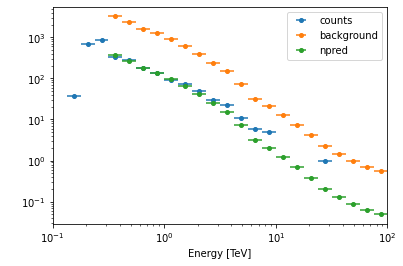

In [55]:
dataset.counts.get_spectrum().plot(label='counts')
dataset.background.get_spectrum().plot(label='background')
dataset.npred().get_spectrum().plot(label='npred')
plt.legend()

In [20]:
obs = observations[0]
print(obs.obs_info)

{'ALT_PNT': 82.78779, 'AZ_PNT': 212.7456, 'DATE-END': '2006-08-19', 'DATE-OBS': '2006-08-19', 'DEADC': 1.0, 'DEC_OBJ': -29.007833, 'DEC_PNT': -29.604733, 'EVENT_COUNT': 2868, 'EVENT_DEC_MEDIAN': -29.584993, 'EVENT_ENERGY_MEDIAN': 0.28876388, 'EVENT_RA_MEDIAN': 265.99078, 'EVENT_TIME_MAX': 177708067.36006165, 'EVENT_TIME_MIN': 177706380.27332234, 'GLAT_PNT': -0.045917418, 'GLON_PNT': 359.24402, 'LIVETIME': 1690.0, 'MUONCORR': 1.0168585, 'MUONEFF': 0.071334995, 'N_TELS': 4, 'OBJECT': 'Sgr A*', 'OBS_ID': 34188, 'ONTIME': 1690.0, 'QUALITY': 1, 'RA_OBJ': 266.41647, 'RA_PNT': 265.99707, 'TELLIST': '1,2,3,4', 'TIME-END': '19:22:13.184', 'TIME-OBS': '18:54:03.184', 'TSTART': 177706379.0, 'TSTOP': 177708069.0, 'ZEN_PNT': 7.2122135, 'BKG_SCALE': 1.0}


In [21]:
print(stacked.models)

None


<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

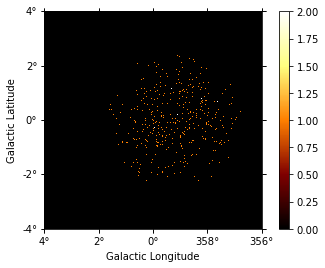

In [11]:
stacked.counts.sum_over_axes().plot(add_cbar=True)

<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

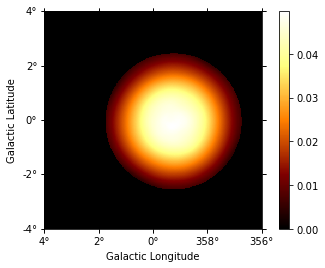

In [12]:
stacked.background.sum_over_axes().plot(add_cbar=True)

<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

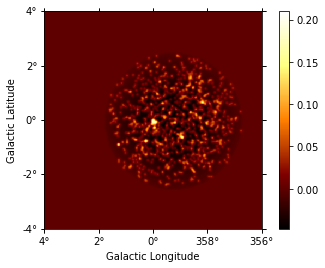

In [14]:
stacked.residuals().sum_over_axes().smooth(2).plot(add_cbar=True)

<AxesSubplot:xlabel='Energy [TeV]', ylabel='$\\mathrm{}$'>

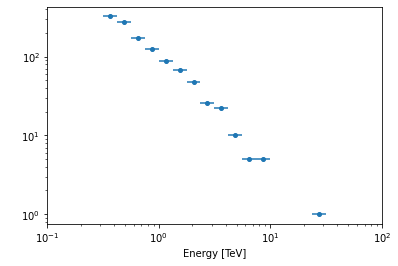

In [16]:
stacked.counts.get_spectrum().plot()

### creating a second version of dataset hess1_1

in this section I want to test what changes if we exclude this only run

In [33]:
import numpy as np
import astropy.units as u
import yaml
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord

from gammapy.maps import MapAxis, WcsGeom, Map
from gammapy.data import DataStore
from gammapy.makers import MapDatasetMaker, SafeMaskMaker, FoVBackgroundMaker
from gammapy.modeling.models import (
    FoVBackgroundModel,
    Models,
)
from gammapy.modeling import Fit
from gammapy.datasets import MapDataset
from gammapy.irf import Background3D

import warnings
warnings.filterwarnings('ignore')

muoneff_flag= True
edisp = True

hessera='hess1'
name_afterFermi = 'v1'
idx = 1 # 0,1,2
full_runlist = np.loadtxt(f'../runlist_{hessera}_{idx}.txt')

# loading general parameters
with open("/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/general_config.yml", "r") as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)
conf=cfg['conf']
repo_path=cfg['repo_path']
N_ebins = cfg['N_ebins']
zen_bins = cfg['zen_bins']

muoneff_path = cfg['muoneff_path']
model_str = cfg['model_str']
energy_bins = np.logspace(-1, 2, N_ebins+1)

basedir = f'$FITS_PROD/{hessera}/std_{conf}_fullEnclosure'
ds = DataStore.from_dir(basedir, f'hdu-index-bg-latest-fov-radec.fits.gz', f'obs-index-bg-latest-fov-radec.fits.gz')
obs_table = ds.obs_table

mask = [True if obsid in full_runlist else False for obsid in obs_table['OBS_ID']]
obs_table=obs_table[mask]

axis = MapAxis.from_edges(energy_bins, unit="TeV", name="energy", interp="log")
binsz=cfg['binsz']*u.deg
maker = MapDatasetMaker()
if edisp:
    maker_safe_mask = SafeMaskMaker(methods=['offset-max', 'bkg-peak', 'edisp-bias'], offset_max=cfg['offset_cut']*u.deg) 
else:
    maker_safe_mask = SafeMaskMaker(methods=['offset-max'], offset_max=cfg['offset_cut']*u.deg)

In [34]:
def create_dataset(runlist, axis, muoneff_flag, name, background_oversampling=1):
    observations = ds.get_observations(runlist)
    maker = MapDatasetMaker()
    geom = WcsGeom.create(skydir=(0,0), binsz=binsz, width=8, frame="galactic", axes=[axis])
    stacked = MapDataset.create(geom=geom)

    norm_tilt_list = []
    for j, obs in enumerate(observations):
        zen_bin = np.sum(obs.pointing_zen.value > zen_bins) - 1
        
        if muoneff_flag:
            muoneff_path=f'/home/saturn/caph/sn0533/shared/hess/fits/bgmodel_3d/prod05/std_zeta_fullEnclosure/{hessera}/hess1_hess2/v01c_kaori_mueff'
            if obs.obs_info['MUONEFF'] > 0.085:
                model_CD = 'B'
            elif obs.obs_info['MUONEFF'] >= 0.075:
                model_CD = 'D'
            else:
                model_CD = 'C'

            if obs.obs_id >= 100000:
                run_number= f'{obs.obs_id}'
            else:
                run_number= f'0{obs.obs_id}'
            filename = f'{muoneff_path}_{model_CD}/hess_bkg_3d_v01c_kaori_mueff_{model_CD}_norebin_fov_radec_{run_number}.fits.gz'
            obs.bkg = Background3D.read(filename, hdu='BACKGROUND')
        
        dataset = stacked.cutout(obs.pointing_radec, width=5)
        dataset = maker.run(dataset, obs)
        
        # this is to set bkg to 0 when it has unreasonable values in the highest energies
        spectrum = np.sum((dataset.background).data, axis=(1,2))
        for i in range(1, 5):
            if spectrum[-1*i] > spectrum[-1*(i+1)]:
                dataset.background.data[-1*i] = 0
        bkg= np.sum((dataset.background).data, axis=(1,2))
        
        dataset = maker_safe_mask.run(dataset, obs)
        
        dataset.mask_fit = Map.from_geom(geom=dataset.counts.geom, data=np.ones_like(dataset.counts.data).astype(bool))   
        dataset.mask_fit &= ~dataset.counts.geom.region_mask(f"galactic;box(0, 0, 4.3, 1.6)")
        dataset.mask_fit &= ~dataset.counts.geom.region_mask(f"galactic;circle(358.71, -0.64, 0.9)")
        
        bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
        dataset.models = Models([bkg_model])
        dataset.background_model.spectral_model.tilt.frozen = False
        Fit().run(datasets=[dataset])
                
        if dataset.background_model.spectral_model.norm.value > 0:
            dataset.background.data[~dataset.mask_safe.data] = 0.0
            stacked.stack(dataset)
            norm_tilt_list.append([obs.obs_id, dataset.background_model.spectral_model.norm.value, dataset.background_model.spectral_model.tilt.value])
        else:
            print(f'run: with problem={obs.obs_id}')
    return stacked

In [37]:
runlist = full_runlist[full_runlist != 34188]

In [39]:
%%time
    
axis = MapAxis.from_edges(np.logspace(-1,2,25), unit="TeV", name="energy", interp="log")
name='test'
stacked = create_dataset(runlist, axis, muoneff_flag, name)

No HDU found matching: OBS_ID = 27575.0, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 27576.0, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 27577.0, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 27592.0, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 27593.0, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 27594.0, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 27595.0, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 27600.0, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 27601.0, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 27602.0, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 27603.0, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 27604.0, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 27606.0, HDU_TYPE = rad_max, HDU

CPU times: user 7min 28s, sys: 20.2 s, total: 7min 48s
Wall time: 7min 52s


In [40]:
stacked.write('dataset_test_hess1_1_no34188.fits')

In [41]:
model_path = f'../fitted_model_20220702_hess1_muoneffTrue_edispTrue_afterFermiv1_1.yml'
original_fit_model =Models.read(model_path)

In [42]:
stacked.models = original_fit_model.copy()

In [44]:
stacked = FoVBackgroundMaker().make_default_fov_background_model(dataset=stacked)
stacked.models[-1].parameters['tilt'].frozen=False

result0= Fit().run(datasets=[stacked])
print(result0)


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 167
	total stat : 628196.03

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 167
	total stat : 628196.03




In [45]:
print(stacked.models)

DatasetModels

Component 0: SkyModel

  Name                      : HESS J1741-302
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index        (frozen)   :      2.300                   
    amplitude    (frozen)   :   2.10e-13       1 / (cm2 s TeV)
    reference    (frozen)   :      1.000       TeV         
    lon_0        (frozen)   :    358.277       deg         
    lat_0        (frozen)   :      0.049       deg         

Component 1: SkyModel

  Name                      : HESS J1745-290
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :      2.228   +/-    0.08             
    amplitude               :   1.98e-12   +/- 1.3e-13 1 / (cm2 s TeV)
    reference    (frozen)   :      1.

In [48]:
central_source = 'HESS J1745-290'

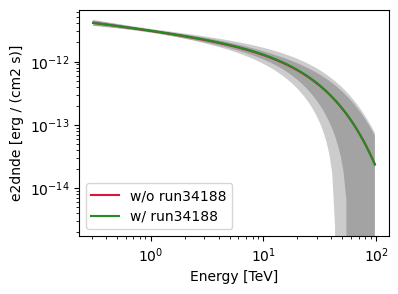

In [54]:
fig, ax = plt.subplots(1,1, figsize=(4, 3), dpi=100)

energy_bounds = [0.3, 100] * u.TeV
sed_type = "e2dnde"

stacked.models[central_source].spectral_model.plot(ax=ax, color='crimson',
        energy_bounds=energy_bounds, sed_type=sed_type, label='w/o run34188')
stacked.models[central_source].spectral_model.plot_error(ax=ax, energy_bounds=energy_bounds, sed_type=sed_type)


original_fit_model[central_source].spectral_model.plot(ax=ax, color='forestgreen',
        energy_bounds=energy_bounds, sed_type=sed_type, label='w/ run34188')
original_fit_model[central_source].spectral_model.plot_error(ax=ax, energy_bounds=energy_bounds, sed_type=sed_type)
plt.legend()

<AxesSubplot:xlabel='Energy [TeV]', ylabel='e2dnde [erg / (cm2 s)]'>

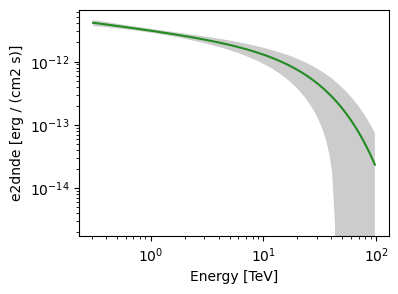

In [53]:
fig, ax = plt.subplots(1,1, figsize=(4, 3), dpi=100)

energy_bounds = [0.3, 100] * u.TeV
sed_type = "e2dnde"

original_fit_model[central_source].spectral_model.plot(ax=ax, color='forestgreen',
        energy_bounds=energy_bounds, sed_type=sed_type)
original_fit_model[central_source].spectral_model.plot_error(ax=ax, energy_bounds=energy_bounds, sed_type=sed_type)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(4, 3), dpi=100)

catalog_model.spectral_model.plot(ax=ax, color='black',
        energy_bounds=energy_bounds, sed_type=sed_type, label='catalog')
    
for idx, hess in enumerate(datasets_hess):
    hess.models[central_source].spectral_model.plot(ax=ax, color=colors[idx],
        energy_bounds=energy_bounds, sed_type=sed_type, label=f'dataset-{idx}')
    hess.models[central_source].spectral_model.plot_error(ax=ax, energy_bounds=energy_bounds, sed_type=sed_type)
plt.legend(loc='lower left')
plt.ylim(1e-15, 2e-11)
plt.title(central_source)